In [2]:
import scirpy as ir
import scvi

In [1]:
import os
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import sparse
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['figure.figsize'] = (7,7)
import seaborn as sns

In [5]:
## IMMUNE CELL FROM TUMORAL MICROENV - TUMOR MODEL (gastro?)

# LOAD DATA

In [6]:
samples = os.listdir('../../raw/')
samples

['L1051', 'L1041', 'L1053', 'L1068', 'L1040', 'L1050', 'L1052', 'L1067']

In [7]:
import pandas as pd
meta = pd.read_excel('../../AJANIC_01_Internal barcoding SCU.xlsx', index_col=0)
meta.columns = meta.iloc[1]
meta = meta.iloc[2:]
meta.index = meta['LIBRARY BARCODE']

# DOUBLETS COMPUTATION

In [8]:
import doubletdetection
clf = doubletdetection.BoostClassifier()

In [ ]:
adatas = []
for i in samples:
    a = sc.read_10x_h5(f'../../raw/{i}/filtered_feature_bc_matrix.h5')
    a.obs['library'] = i
    a.obs['sample_barcode'] = meta.loc[i]['SAMPLE BARCODE']
    a.obs['sample_name'] = meta.loc[i]['SAMPLE  NAME']
    a.obs['source'] = meta.loc[i]['SAMPLE SOURCE']
    a.var_names_make_unique()
    a.obs['DoubletDetection'] = clf.fit(a.X.copy()).predict()
    a.obs['DoubletDetection_score'] = clf.doublet_score()
    adatas.append(a)

In [ ]:
adata = ad.concat(adatas,index_unique='_',keys=samples,label=None, join='outer')
adata.obs_names_make_unique()
print(adata.obs["sample_barcode"].value_counts())
adata

sample_barcode
S741    12811
S746    10925
S744     9865
S743     9854
S761     9767
S745     9508
S760     9165
S742     8773
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 80668 × 33696
    obs: 'library', 'sample_barcode', 'sample_name', 'source', 'DoubletDetection', 'DoubletDetection_score'

In [ ]:
adata.write('../objects/data.h5ad', compression='gzip')

# QC METRCIS

In [1]:
import os
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import sparse
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['figure.figsize'] = (7,7)
import seaborn as sns

In [2]:
adata = sc.read('../objects/data.h5ad')
adata.obs['sample'] = adata.obs['library']

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("Mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(('Rpl', 'Rps', 'Mrpl', 'Mrps'))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^Hb[^(p)]")

In [3]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)    

In [4]:
list_val = []
list_sample = []
for i in adata.obs['sample'].unique():
    prim = adata[adata.obs['sample'].isin([i])]
    list_val.append(np.sum(prim.obs['n_genes_by_counts'])/prim.shape[0])
    list_sample.append(i)
sort_l = np.argsort(list_val)
order = [list_sample[i] for i in sort_l]

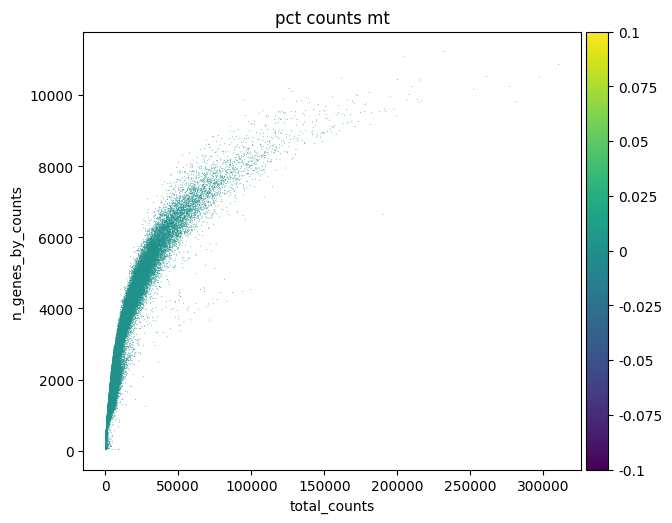

In [11]:
rcParams['figure.figsize'] = (6,6)

sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")


In [12]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

In [13]:
adata.write('../objects/data_qc.h5ad', compression='gzip')

# DIMENSIONALITY REDUCTION

In [13]:
import os
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import sparse
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['figure.figsize'] = (7,7)
import seaborn as sns
from harmonypy import run_harmony


In [2]:
adata = sc.read('../objects/data_qc.h5ad', compression='gzip')

In [3]:
adata.layers["counts"] = adata.X.copy()
adata.raw = adata.copy()

## CHECK SCALING THE DATA

In [ ]:
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample", flavor='seurat_v3', layer = 'counts')
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)


/home/macera/.local/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)
adata.obsm['X_umap_RAW_scaled'] = adata.obsm['X_umap']

In [23]:

sc.tl.pca(adata)
ho = run_harmony(adata.obsm['X_pca'], adata.obs, vars_use = ['sample'], max_iter_harmony=20)


2025-05-15 16:01:48,377 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-15 16:02:11,685 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-15 16:02:12,033 - harmonypy - INFO - Iteration 1 of 20
2025-05-15 16:02:40,201 - harmonypy - INFO - Iteration 2 of 20
2025-05-15 16:03:10,437 - harmonypy - INFO - Iteration 3 of 20
2025-05-15 16:03:43,657 - harmonypy - INFO - Iteration 4 of 20
2025-05-15 16:04:26,834 - harmonypy - INFO - Iteration 5 of 20
2025-05-15 16:04:38,774 - harmonypy - INFO - Iteration 6 of 20
2025-05-15 16:04:49,317 - harmonypy - INFO - Iteration 7 of 20
2025-05-15 16:04:59,263 - harmonypy - INFO - Iteration 8 of 20
2025-05-15 16:05:09,426 - harmonypy - INFO - Iteration 9 of 20
2025-05-15 16:05:33,272 - harmonypy - INFO - Iteration 10 of 20
2025-05-15 16:05:54,067 - harmonypy - INFO - Iteration 11 of 20
2025-05-15 16:06:04,120 - harmonypy - INFO - Converged after 11 iterations


In [24]:
harmonized = pd.DataFrame(ho.Z_corr.T, index = adata.obs.index)
# Write the adjusted PCs to a new file.
adata.obsm['X_Harmony_scaled'] = harmonized.values


sc.pp.neighbors(adata, n_pcs=30, use_rep='X_Harmony_scaled')
sc.tl.umap(adata)
adata.obsm['X_umap_Harmony_scaled'] = adata.obsm['X_umap']

In [ ]:
sc.pp.neighbors(adata, n_pcs=30, use_rep='X_Harmony_scaled')
for res in [0.3,0.5,0.7]:
    sc.tl.leiden(adata, resolution=res, key_added=f'leiden_{res}', flavor="igraph", n_iterations=5)

In [25]:
for res in [0.1,0.15]:
    sc.tl.leiden(adata, resolution=res, key_added=f'leiden_{res}', flavor="igraph", n_iterations=5)

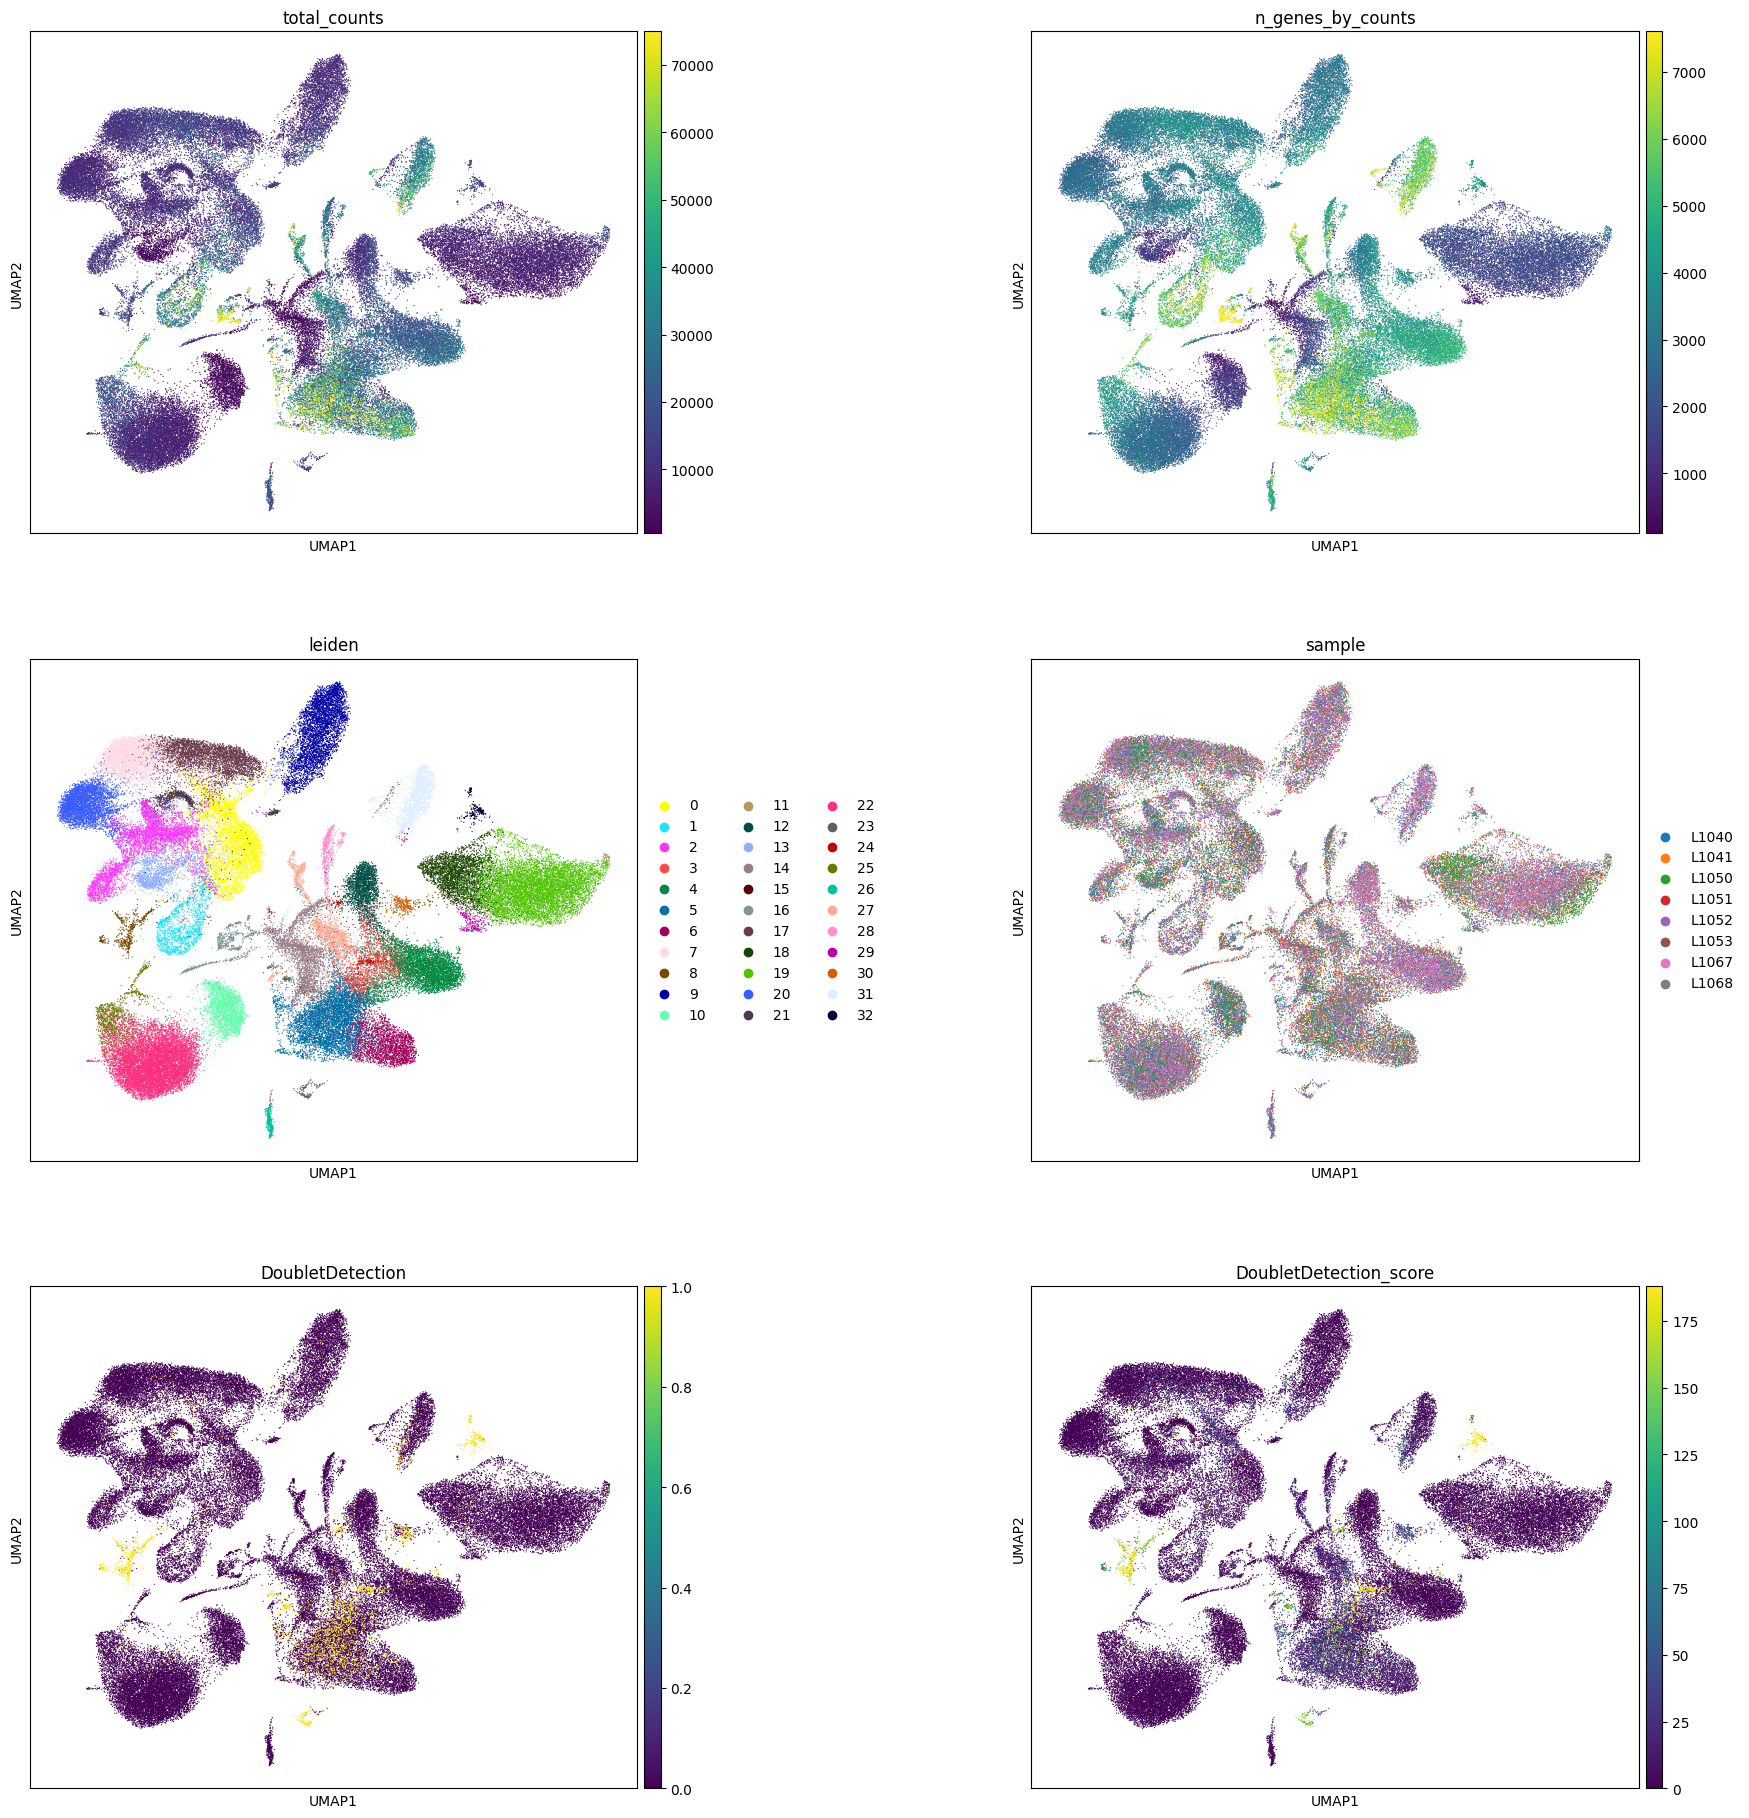

In [ ]:
sc.pl.umap(
    adata,
    color=['total_counts','n_genes_by_counts',"leiden", 'sample', "DoubletDetection", "DoubletDetection_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,ncols=2, vmax='p99'
)

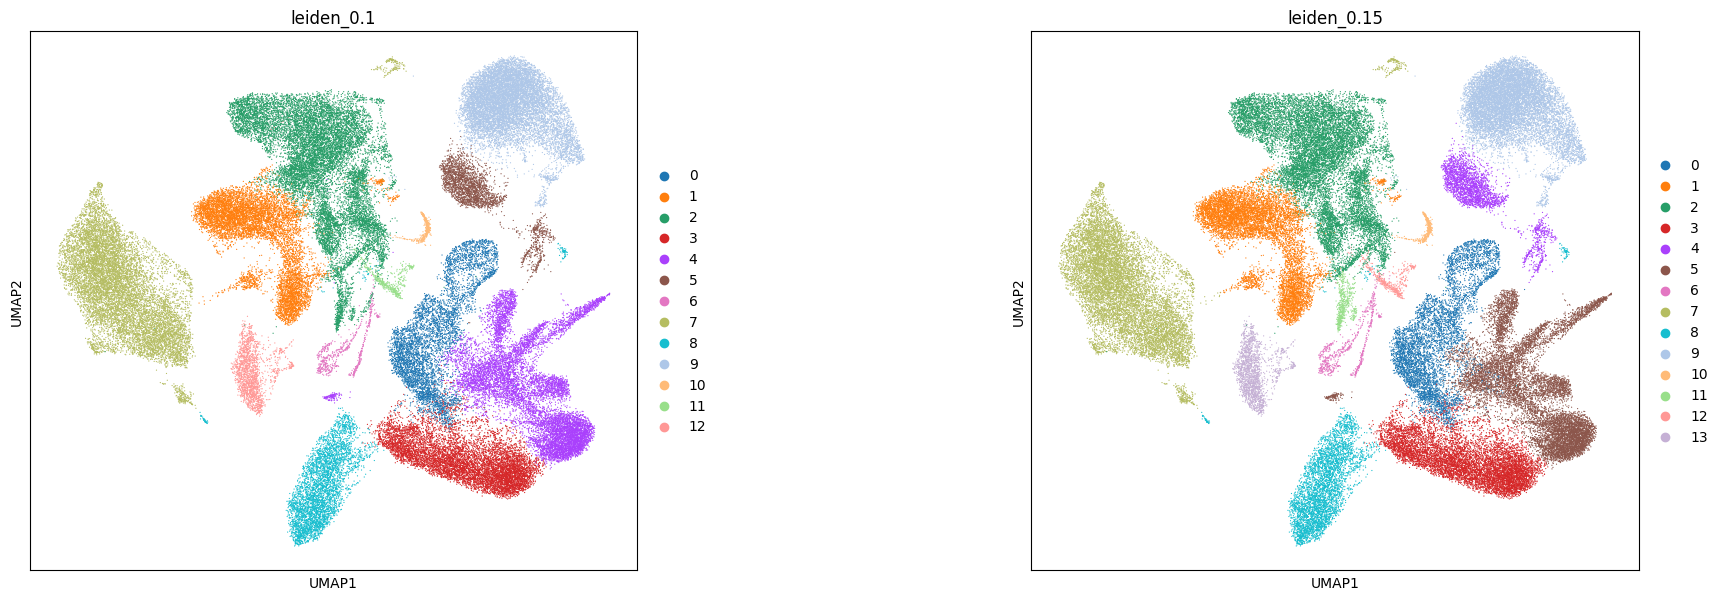

In [26]:

leidens=[]
for res in [0.1,0.15]:
    leidens.append(f'leiden_{res}')
sc.pl.umap(
    adata,
    color=leidens,
    # increase horizontal space between panels
    wspace=0.5,
    size=3,ncols=2, vmax='p99'
)

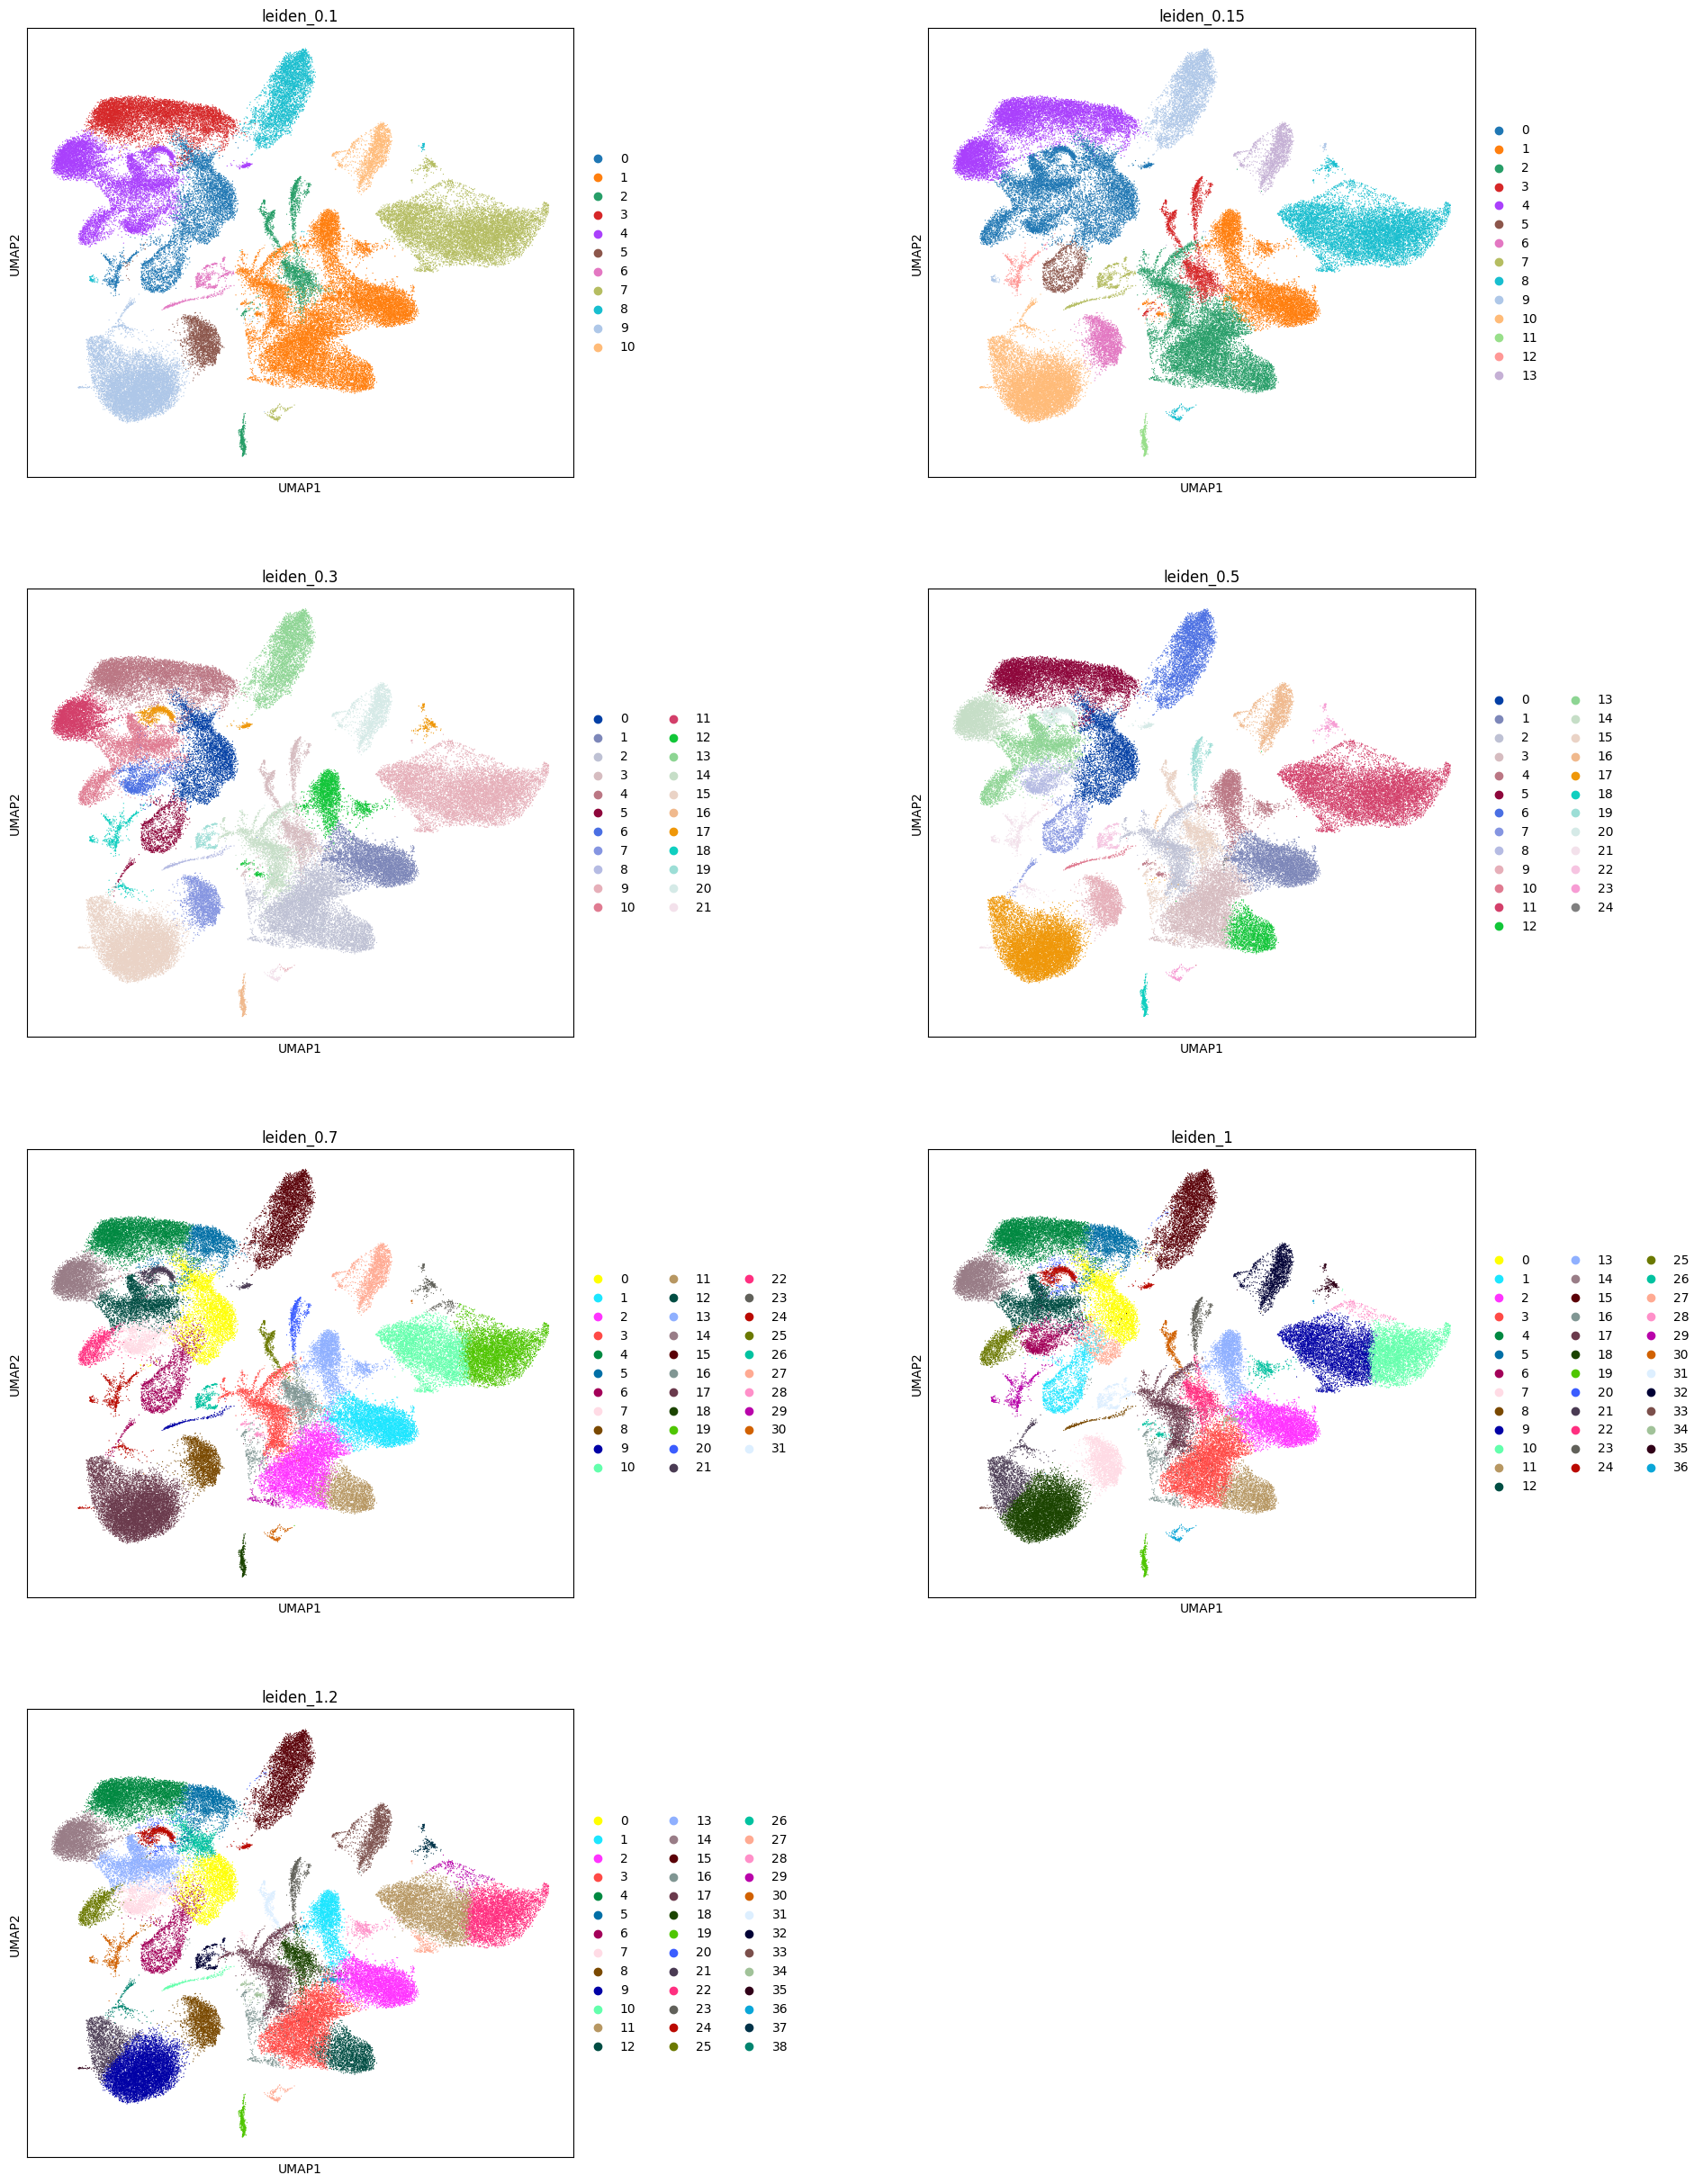

In [ ]:

leidens=[]
for res in [0.1,0.15,0.3,0.5,0.7]:
    leidens.append(f'leiden_{res}')
sc.pl.umap(
    adata,
    color=leidens,
    # increase horizontal space between panels
    wspace=0.5,
    size=3,ncols=2, vmax='p99'
)

In [ ]:
adata.write('../objects/data_processed.h5ad', compression='gzip')

# DE

In [46]:
import os
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import sparse
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['figure.figsize'] = (7,7)
import seaborn as sns

In [182]:
adata = sc.read('../objects/data_processed.h5ad', compression='gzip')

In [ ]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")


/home/macera/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/macera/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/macera/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:440: PerformanceWarning: DataFrame is highly fragmented.  Th

In [ ]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        f"{group}_{key[:1]}": result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).to_csv('../objects/Markers_leiden1_hvg.csv')

In [93]:
sc.tl.rank_genes_groups(adata, "leiden_0.1", method="wilcoxon")
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        f"{group}_{key[:1]}": result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).to_csv('../objects/Markers_leiden01_hvg.csv')

In [ ]:
sc.tl.rank_genes_groups(adata, "leiden_0.15", method="wilcoxon")
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        f"{group}_{key[:1]}": result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).to_csv('../objects/Markers_leiden015.csv')

In [56]:
adata

AnnData object with n_obs × n_vars = 80570 × 25760
    obs: 'library', 'sample_barcode', 'sample_name', 'source', 'DoubletDetection', 'DoubletDetection_score', 'n_genes', 'sample', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap', 'rank_genes_groups'
    obsm: 'X_Harmony', 'X

In [60]:
result.keys()

dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])

In [ ]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon", )

In [ ]:

result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        f"{group}_{key}": result[key][group]
        for group in groups
        for key in ["names","scores","pvals","logfoldchanges"]
    }
).to_csv('../objects/Markers_leiden1_full.csv')

In [63]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        f"{group}_{key}": result[key][group][0:30]
        for group in groups
        for key in ["names","scores","pvals","logfoldchanges"]
    }
).to_csv('../objects/Markers_leiden1_top30.csv')

# ANNOTATE FIRST LAYER - LEIDEN 0.15

In [121]:
adata.obs['leiden_0.15'].unique()

['0', '1', '2', '4', '5', ..., '10', '11', '3', '12', '13']
Length: 14
Categories (14, object): ['0', '1', '2', '3', ..., '10', '11', '12', '13']

In [ ]:
df = pd.read_csv('../objects/Markers_leiden015.csv')
from collections import defaultdict

# Extract top genes for each cluster
cluster_annotations = {}
cluster_marker_genes = defaultdict(list)

# Iterate through clusters (0 to 32)
num_clusters = len(adata.obs['leiden_0.15'].unique())
for cluster_id in range(num_clusters):
    name_col = f"{cluster_id}_n"
    if name_col in df.columns:
        top_genes = df[name_col].dropna().tolist()
        cluster_marker_genes[cluster_id] = top_genes

# Display example genes from the first few clusters
example_clusters = {cid: genes[:10] for cid, genes in list(cluster_marker_genes.items())}
example_clusters

{0: ['Cd3e',
  'Cd3g',
  'Icos',
  'Skap1',
  'Rora',
  'Lat',
  'Ctla4',
  'Cd3d',
  'Camk4',
  'Itk'],
 1: ['Plac8',
  'Clec4a3',
  'Ifitm3',
  'Ms4a6c',
  'Lyz2',
  'Clec4a1',
  'Cybb',
  'Pld4',
  'Ifitm6',
  'Gpx1'],
 2: ['Lrp1',
  'Lgmn',
  'Ctsb',
  'Tgfbi',
  'Fcgr2b',
  'Rrbp1',
  'Mafb',
  'Msr1',
  'Ctss',
  'Psap'],
 3: ['H2-Eb1',
  'Syngr2',
  'H2-Aa',
  'H2-Ab1',
  'Atox1',
  'Cst3',
  'Cd74',
  'Ifi30',
  'Htr7',
  'Cbfa2t3'],
 4: ['Rplp1',
  'Rps16',
  'Rplp2',
  'Tcf7',
  'Rpl5',
  'Rpl12',
  'Tpt1',
  'Rps15a',
  'Rps10',
  'Rps7']}

In [154]:
example_clusters = {cid: genes[:20] for cid, genes in list(cluster_marker_genes.items())}
example_clusters

{0: ['Cd3e',
  'Cd3g',
  'Icos',
  'Skap1',
  'Rora',
  'Lat',
  'Ctla4',
  'Cd3d',
  'Camk4',
  'Itk',
  'Lck',
  'Thy1',
  'Ndfip1',
  'Ptpn22',
  'Bcl11b',
  'Grap2',
  'Trac',
  'Cd5',
  'Themis',
  'Cd247'],
 1: ['Plac8',
  'Clec4a3',
  'Ifitm3',
  'Ms4a6c',
  'Lyz2',
  'Clec4a1',
  'Cybb',
  'Pld4',
  'Ifitm6',
  'Gpx1',
  'Smpdl3a',
  'Csf1r',
  'Cst3',
  'Napsa',
  'Gm36161',
  'Ms4a4a',
  'Psap',
  'Lst1',
  'Gm21188',
  'Rassf4'],
 2: ['Lrp1',
  'Lgmn',
  'Ctsb',
  'Tgfbi',
  'Fcgr2b',
  'Rrbp1',
  'Mafb',
  'Msr1',
  'Ctss',
  'Psap',
  'Zeb2',
  'Ctsz',
  'Fn1',
  'App',
  'Ctsl',
  'Grn',
  'Dab2',
  'Cndp2',
  'Ecm1',
  'Mt1'],
 3: ['H2-Eb1',
  'Syngr2',
  'H2-Aa',
  'H2-Ab1',
  'Atox1',
  'Cst3',
  'Cd74',
  'Ifi30',
  'Htr7',
  'Cbfa2t3',
  'Basp1',
  'Cxcl16',
  'Jak2',
  'Olfm1',
  'Etv3',
  'H2-DMb1',
  'Ptms',
  'Rogdi',
  'Zfp366',
  'Irf5'],
 4: ['Rplp1',
  'Rps16',
  'Rplp2',
  'Tcf7',
  'Rpl5',
  'Rpl12',
  'Tpt1',
  'Rps15a',
  'Rps10',
  'Rps7',
  'Rps24',
  '

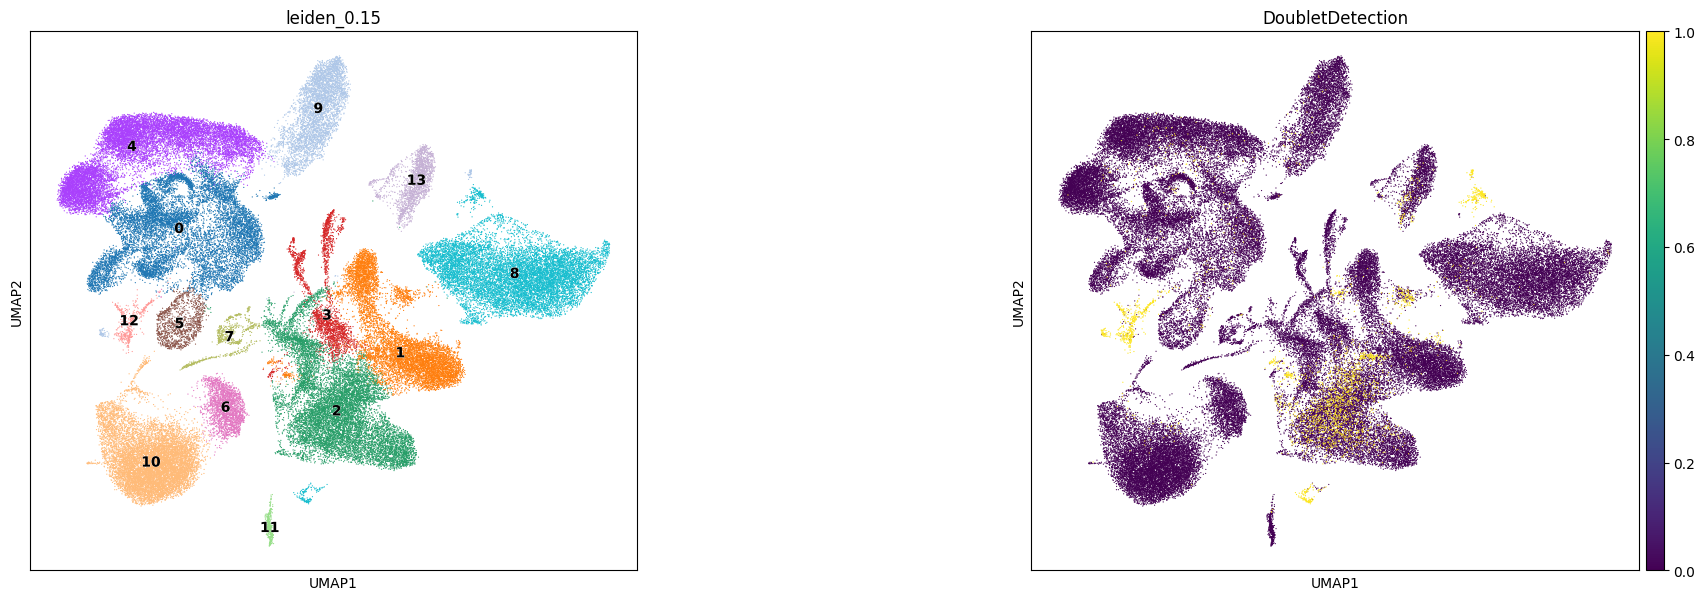

In [156]:
sc.pl.umap(
    adata,
    color=["leiden_0.15","DoubletDetection"],
    # increase horizontal space between panels
    wspace=0.5,legend_loc='on data',legend_fontoutline=0.4,
    size=3,ncols=2, vmax='p99'
)

In [30]:
adata.obs['Annotation_l1']=''
adata.obs.loc[adata.obs['leiden_0.15'].isin(['0','4']),'Annotation_l1'] = 'T_cells' # 0: Classic T cell markers (Cd3e/g/d, Lat) with activation/regulatory signals (Icos, Ctla4, Rora, Camk4) // 4: Ribosomal signature + Tcf7 (naive T marker)
adata.obs.loc[adata.obs['leiden_0.15'].isin(['5']),'Annotation_l1'] = 'Cycling/Proliferating' # Strong proliferation signature
adata.obs.loc[adata.obs['leiden_0.15'].isin(['1']),'Annotation_l1'] = 'Monocytes' # Classical Myeloid profile with Plac8, Lyz2, Clec4a3, and Ifitm3
adata.obs.loc[adata.obs['leiden_0.15'].isin(['2']),'Annotation_l1'] = 'Macrophages' # Resident Macrophages - Tissue-resident / reparative macrophage genes (Mafb, Msr1, Ctss)
adata.obs.loc[adata.obs['leiden_0.15'].isin(['3']),'Annotation_l1'] = 'cDC2'# Conventional Dendritic Cells (cDC2) - High MHC-II expression with Cd74, suggestive of antigen-presenting cells
adata.obs.loc[adata.obs['leiden_0.15'].isin(['6','10']),'Annotation_l1'] = 'B_cells' # 6: B cell transcription factors (Pax5, Ebf1) -Early B cell progenitors / Pro-B cells // 
adata.obs.loc[adata.obs['leiden_0.15'].isin(['9']),'Annotation_l1'] = 'NK'# Classic NK cell cytotoxic profile
adata.obs.loc[adata.obs['leiden_0.15'].isin(['8']),'Annotation_l1'] = 'Neutrophils' #  Inflammatory Neutrophils - Granulocytic with inflammation markers
adata.obs.loc[adata.obs['leiden_0.15'].isin(['7']),'Annotation_l1'] = 'Stromal/Mesenchymal' # Likely stromal/fibroblast contamination or mesenchymal stem cells
adata.obs.loc[adata.obs['leiden_0.15'].isin(['11']),'Annotation_l1'] = 'pDCs' #  Signature for plasmacytoid dendritic cells (pDCs)
adata.obs.loc[adata.obs['leiden_0.15'].isin(['12']),'Annotation_l1'] = 'B_cells' # Mature/Transitional B cells
adata.obs.loc[adata.obs['leiden_0.15'].isin(['13']),'Annotation_l1'] = 'M2/moDCs' # Monocyte-derived reparative macrophages / moDCs with M2-like features - These cells are often immunoregulatory, lipid-processing, and involved in clearance of apoptotic cells (efferocytosis).

In [39]:
adata_obs.to_csv('../objects/metadata_cluster_annotation.h5ad')

In [33]:
adata.obs['Annotation_l1'] = adata_obs['Annotation_l1']

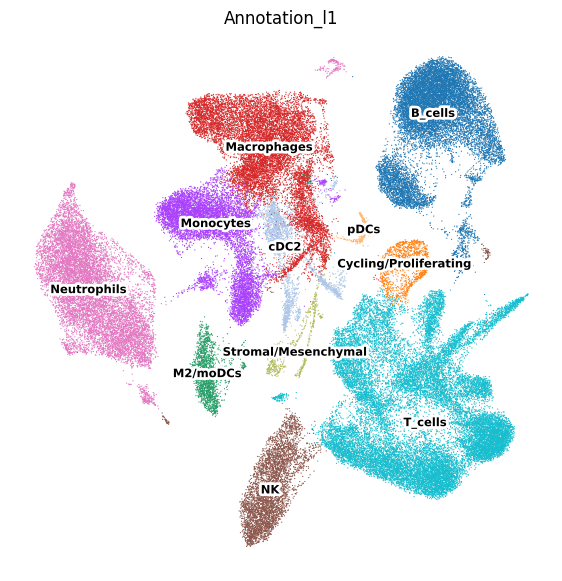

In [34]:
sc.pl.umap(
    adata,
    color=["Annotation_l1"],
    # increase horizontal space between panels
    wspace=0.5,legend_loc='on data',legend_fontsize='small',legend_fontoutline=4,
    size=3,ncols=2, vmax='p99', frameon=False
)

In [35]:
adata.write('../objects/data_annotated_l1.h5ad', compression='gzip')